In [93]:
from docplex.cp.model import *
from docplex.cp.config import get_default
from config import setup
import random
setup()

In [94]:
# Given instance

Lhs = [
    [2,3,1,4],
    [4,1,3,2],
    [2,4,1,3],
    [3,1,4,2]
]
Lfs = [
    [2,1,3,4],
    [3,4,1,2],
    [1,3,4,2],
    [2,1,3,4]
]

In [95]:
# Function that generated random instance given a size

def random_instance(n):
    Lh = []
    Lf = []
    for i in range(n):
        lh = [i for i in range(1,n+1)]
        lf = [i for i in range(1,n+1)]
        random.shuffle(lh)
        random.shuffle(lf)
        Lh.append(lh)
        Lf.append(lf)
    return Lh,Lf
    

In [96]:
# Function that generates a model given two lists of preferences (h & f)

def generate_model(Lh , Lf):
    
    mdl = CpoModel(name="MariageStable")
    
    n = len(Lh)
    
    # Variables of the model (if x[i][j]==1 then i and j are a couple)
    x = [mdl.binary_var_list(n, f"{y}") for y in range(n)]
    
    # Positions in Lh and Lf
    Dh = mdl.integer_var_list(n,0,n-1,'Dh')
    Df = mdl.integer_var_list(n,0,n-1,'Df')
    
    
    #Adding constraints

    #Each agent can only be with one partner
    for i in range(n):
        mdl.add(sum([x[i][j] for j in range(n)]) == 1)

    for j in range(n):
        mdl.add(sum([x[i][j] for i in range(n)]) == 1)


    #Current spouses of each agent
    for i in range(n):
        mdl.add(Dh[i] == sum([ (x[i][f] * Lh[i].index(f+1)) for f in range(n)]))

    for j in range(n):
        mdl.add(Df[j] == sum([ (x[h][j] * Lf[j].index(h+1)) for h in range(n)]))

    # Blocking couple
    for i in range(n):
        for j in range(n):
            mdl.add((Dh[i]>Lh[i].index(j+1)) & (Df[j]>Lf[j].index(i+1)) == false())
    return mdl, x

In [97]:
# Function than print the solution

def print_sol(sol) :
    couples_vars = [var.get_name() for var in sol.get_all_var_solutions() if var.get_value() == 1]
    couples = []
    for m in couples_vars:
        h, f = m.split('_')
        if h.isnumeric() and f.isnumeric() :
            couples.append("(h{},f{})".format(int(h)+1,int(f)+1))

    print(', '.join(couples))

In [98]:
model, x = generate_model(Lhs,Lfs)

In [99]:

sols = model.start_search(SearchType="DepthFirst",LogVerbosity = 'Quiet')
print("Solutions for the problem: ")

for solution in sols:
    print_sol(solution)


Solutions for the problem: 
(h1,f3), (h2,f4), (h3,f2), (h4,f1)


In [100]:
# Strategies comparaison

import warnings 
warnings.filterwarnings('ignore')

# Lists for plotting
exec_time_d1 = []
nodes_d1 = []
exec_time_d2 = []
nodes_d2 = []
exec_time_r1 = []
nodes_r1 = []
exec_time_r2 = []
nodes_r2 = []

sizes = [5,10,15,20,25]
for n in sizes:

    # Generate model for each strategy
    
    Lh,Lf = random_instance(n)
    model_S1, x1 = generate_model(Lh, Lf)
    model_S2, x2 = generate_model(Lh, Lf)
        
    # Apply search strategy
    
    model_S1.add_search_phase(
    model_S1.search_phase([j for i in x1 for j in i],
                            varchooser=model_S1.select_random_var(),
                            valuechooser=model_S1.select_smallest(value())))
    model_S2.add_search_phase(
    model_S2.search_phase([j for i in x2 for j in i],
                            varchooser=model_S2.select_random_var(),
                            valuechooser=model_S2.select_random_value()))
    # Solving
    
    sol = model_S1.solve(LogVerbosity = 'Quiet', SearchType="DepthFirst", TimeLimit=200)
    nodes_d1.append(sol.get_solver_info('NumberOfChoicePoints'))
    exec_time_d1.append(sol.get_solver_info('TotalTime'))
    
    sol = model_S1.solve(LogVerbosity = 'Quiet', SearchType="Restart", TimeLimit=200)
    nodes_r1.append(sol.get_solver_info('NumberOfChoicePoints'))
    exec_time_r1.append(sol.get_solver_info('TotalTime'))
    
    sol = model_S2.solve(LogVerbosity = 'Quiet', SearchType="DepthFirst", TimeLimit=200)
    nodes_d2.append(sol.get_solver_info('NumberOfChoicePoints'))
    exec_time_d2.append(sol.get_solver_info('TotalTime'))
    
    sol = model_S2.solve(LogVerbosity = 'Quiet', SearchType="Restart", TimeLimit=200)
    nodes_r2.append(sol.get_solver_info('NumberOfChoicePoints'))
    exec_time_r2.append(sol.get_solver_info('TotalTime'))


    

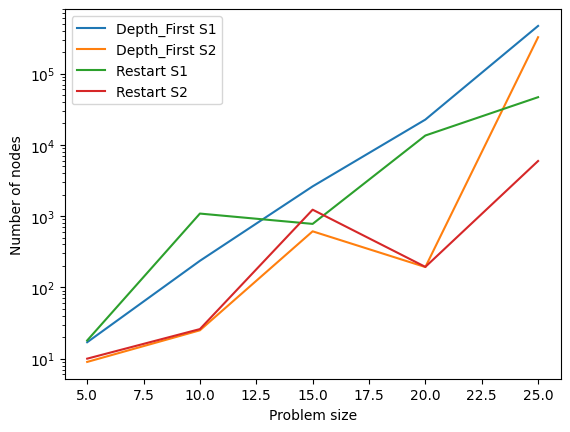

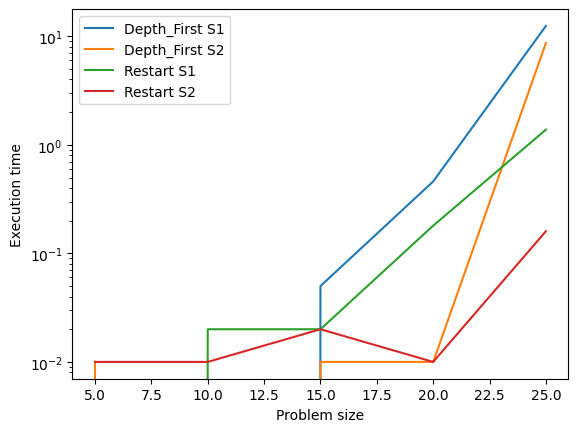

In [101]:
# Results
import matplotlib.pyplot as plt

plt.plot(sizes, nodes_d1, label="Depth_First S1")
plt.plot(sizes, nodes_d2, label="Depth_First S2")
plt.plot(sizes, nodes_r1, label="Restart S1")
plt.plot(sizes, nodes_r2, label="Restart S2")
plt.yscale("log")
plt.xlabel('Problem size')
plt.ylabel('Number of nodes')
plt.legend()
plt.show()

plt.plot(sizes, exec_time_d1, label="Depth_First S1")
plt.plot(sizes, exec_time_d2, label="Depth_First S2")
plt.plot(sizes, exec_time_r1, label="Restart S1")
plt.plot(sizes, exec_time_r2, label="Restart S2")
plt.yscale("log")
plt.xlabel('Problem size')
plt.ylabel('Execution time')
plt.legend()
plt.show()

<h2> PART 2 <h2/>

In [102]:
def minimization_model(Lh,Lf) :
    
    mdl = CpoModel(name="MariageStable")
    
    n = len(Lh)
    # Variables of the model (if x[i][j]==1 then i and j are a couple)
    x = [mdl.binary_var_list(n, f"{y}") for y in range(n)]
    
    # Positions in Lh and Lf
    Dh = mdl.integer_var_list(n,0,n-1,'Dh')
    Df = mdl.integer_var_list(n,0,n-1,'Df')
    
    
    #Adding constraints

    #Each agent can only be with one partner
    for i in range(n):
        mdl.add(sum([x[i][j] for j in range(n)]) == 1)

    for j in range(n):
        mdl.add(sum([x[i][j] for i in range(n)]) == 1)


    #Position of the partner in the ranking:
    for i in range(n):
        mdl.add(Dh[i] == sum([ (x[i][f] * Lh[i].index(f+1)) for f in range(n)]))

    for j in range(n):
        mdl.add(Df[j] == sum([ (x[h][j] * Lf[j].index(h+1)) for h in range(n)]))

    #Blocking couple definition
    for i in range(n):
        for j in range(n):
            mdl.add((Dh[i]>Lh[i].index(j+1)) & (Df[j]>Lf[j].index(i+1)) == false())
    
    #Defining variables for the worst satisfaction for H and F
    max_Dh = mdl.integer_var(name="max_Dh")
    max_Df = mdl.integer_var(name="max_Df")
    
    mdl.add(max_Dh==max([Dh[i] for i in range(n)]))
    mdl.add(max_Df==max([Df[j] for j in range(n)]))
    
    #Minimizing the worst satisfaction
    mdl.add(minimize(abs(max_Dh-max_Df)))
    
    return mdl, x

In [103]:
model1, x= minimization_model(Lhs,Lfs)

In [104]:
sols1 = model1.start_search(SearchType="DepthFirst",LogVerbosity = 'Quiet')

print("Solutions for the problem: ")

for solution in sols1:
    print_sol(solution)

Solutions for the problem: 
(h1,f3), (h2,f4), (h3,f2), (h4,f1)


In [105]:
# Solve instances of multiples sizes with different configurations to compare results

exec_time_d1 = []
nodes_d1 = []
exec_time_d2 = []
nodes_d2 = []

for n in sizes:
    
    # Generate model for each strategy
    
    Lh,Lf = random_instance(n)
    model_S1, x1 = minimization_model(Lh, Lf)
    model_S2, x2 = minimization_model(Lh, Lf)
        
    # Apply search strategy
    
    model_S1.add_search_phase(
    model_S1.search_phase([j for i in x1 for j in i],
                            varchooser=model_S1.select_random_var(),
                            valuechooser=model_S1.select_smallest(value())))
    model_S2.add_search_phase(
    model_S2.search_phase([j for i in x2 for j in i],
                            varchooser=model_S2.select_random_var(),
                            valuechooser=model_S2.select_random_value()))
    # Solving
    
    sol = model_S1.solve(LogVerbosity = 'Quiet', SearchType="DepthFirst", TimeLimit=200)
    nodes_d1.append(sol.get_solver_info('NumberOfChoicePoints'))
    exec_time_d1.append(sol.get_solver_info('TotalTime'))
    
    sol = model_S2.solve(LogVerbosity = 'Quiet', SearchType="DepthFirst", TimeLimit=200)
    nodes_d2.append(sol.get_solver_info('NumberOfChoicePoints'))
    exec_time_d2.append(sol.get_solver_info('TotalTime'))
    

        

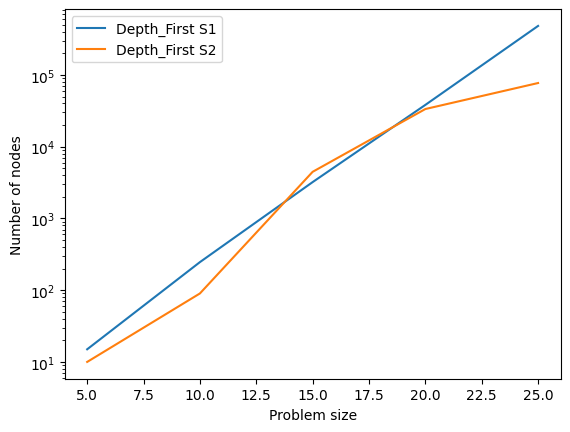

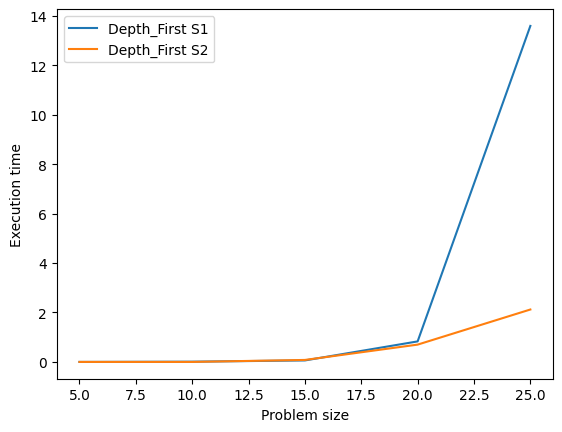

In [106]:
# Results
plt.plot(sizes, nodes_d1, label="Depth_First S1")
plt.plot(sizes, nodes_d2, label="Depth_First S2")
plt.yscale("log")
plt.xlabel('Problem size')
plt.ylabel('Number of nodes')
plt.legend()
plt.show()

plt.plot(sizes, exec_time_d1, label="Depth_First S1")
plt.plot(sizes, exec_time_d2, label="Depth_First S2")
#plt.yscale("log")
plt.xlabel('Problem size')
plt.ylabel('Execution time')
plt.legend()
plt.show()